In [1]:
%matplotlib notebook
import matplotlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

from matplotlib import colors

from fridge import Fridge
from tes import TES
from QET import QET
from detector import Detector
from electronics import Electronics
from absorber import Absorber
from simulated_noise import simulate_noise
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from MaterialProperties import TESMaterial

In [2]:
printing = False
fSnolab = Fridge("SNOLAB", 20e-3, 145e-3, 900e-3, 4.8, 0)
# Absorber: Silicon. Height 1mm. Radius 38.1mm. W safety 3mm. 
# Q: W safety removes a huge % of patterned surface area
absorber = Absorber("Si", "square", 1e-3, 10e-3, 3e-3, printing) # same as matlab
eSnolab = Electronics(fSnolab, fSnolab.get_TCP(), fSnolab.get_TMC())
eSLAC = Electronics(fSnolab, fSnolab.get_TMC(), fSnolab.get_TMC(), 5e-3, 6e-3, 25e-9, 25e-9, 4e-12)

tungsten = TESMaterial()

In [3]:
tes_w = 2.5e-6

h_fin = 900e-9 
ahole = 49e-12
sigma = tungsten._gPep_v

T_eq = -100

l_overlaps = [4e-6, 6e-6, 8e-6, 10e-6, 12e-6, 14e-6, 16e-6, 18e-6, 20e-6, 22e-6,24e-6, 30e-6]
l_fins = [50e-6, 55e-6, 60e-6, 65e-6, 70e-6, 75e-6, 80e-6, 85e-6, 90e-6, 95e-6, 100e-6,  125e-6, 150e-6, 175e-6, 200e-6, 225e-6]
tes_lengths = [25e-6, 30e-6, 35e-6, 40e-6, 45e-6, 50e-6, 55e-6,65e-6, 75e-6, 85e-6, 95e-6, 105e-6, 115e-6, 125e-6, 135e-6, 145e-6]

l_fins_mu = []
l_overlaps_mu = []
tes_lengths_mu = []

for l_o in l_overlaps:
    l_overlaps_mu.append(l_o*(10**6))
for l_f in l_fins:
    l_fins_mu.append(l_f*(10**6))
for t in tes_lengths:
    tes_lengths_mu.append(t*(10**6))
    
n_fins = [2, 4]

In [4]:
# Active Al Percentage
coverages_4fin = []
coverages_2fin = []

# Passive Al Percentage
pass_area_4fin = []
pass_area_2fin = []

# Total Al Percentage
tot_cov_4fin = []
tot_cov_2fin =[]

# Baseline Energy Resolution 
res_4fin = []
res_2fin = []

# Normal TES Resistance
rn_4fin = []
rn_2fin = []

# TES Length 
tes_l_4fin = []
tes_l_2fin = []

# Fin Length 
fin_l_4fin = []
fin_l_2fin = []

# Total Absorption Efficiency
tot_eff_4fin = []
tot_eff_2fin = []

# QP Absorption Eff
qp_eff_4fin = []
qp_eff_2fin = []

In [5]:
# 4 Fin Designs
n_fin = 4

# Require 4% Coverage 
coverage = 0.04

min_resolution = 200

for l_f in l_fins:
    for tes_l in tes_lengths:
        for l_over in l_overlaps:
            perim = tes_l*2 + 14e-6*2 - 6e-6*n_fin
            overlap_p = n_fin*l_over*2
            if overlap_p > perim: 
                continue
            
            # Calculate QET Active Area
            wempty = 6e-6
            wempty_tes = 7.5e-6
            nhole = 3*n_fin 
            afin_empty = n_fin * l_f * wempty + 2 * tes_l * wempty_tes + nhole * ahole                          
            a_fin = np.pi*l_f*(l_f + (tes_l/2)) - afin_empty   
            
            N_tes = coverage*absorber._SA/a_fin
            N_tes = int(N_tes)
         
            
            res_n = tungsten._rho_electrical*tes_l/(tes_w*(40e-9)*N_tes)
            
            tes = TES(tes_l, tes_w, l_over, n_fin, sigma, T_eq, res_n, 0.45, tungsten, printing)
            qet = QET( l_f, h_fin, tes, ahole)
                
            det = Detector("det name", fSnolab, eSLAC, absorber, qet, tes, 1, 0)
            e_res = simulate_noise(det)
            
            if e_res < min_resolution: 
                min_resolution = e_res
                tes_opt = tes
                qet_opt = qet
                det_opt = det 
            
print("BASELINE RESOLUTION: ", min_resolution) 

pActiveArea = det_opt._SA_active/det_opt._absorber.get_SA()
pPassiveArea = det_opt._SA_passive/det_opt._absorber.get_SA()
res_4fin.append(min_resolution)
coverages_4fin.append(pActiveArea)
rn_4fin.append(tes_opt._total_res_n)
tes_l_4fin.append(tes_opt._l)
tot_eff_4fin.append(det_opt._eEabsb)
pass_area_4fin.append(pPassiveArea)
tot_cov_4fin.append(det_opt._fSA_qpabsorb)
qp_eff_4fin.append(det_opt._qet._eQPabsb)

print("TES Length             ", tes_opt._l)
print("Fin Length             ", qet_opt._l_fin)
print("Overlap                ", qet_opt.l_overlap)
print("N Fins                 ", tes_opt._n_fin)
print("Percent Active SA      ", pActiveArea)
print("Percent Passive SA     ", pPassiveArea)
print("Percent QP Absorb SA   ", det_opt._fSA_qpabsorb)
print("N tes                  ", det_opt._tes._nTES)
print("Rn                     ", det_opt._tes._total_res_n )
print("fQP Absorb             ", det_opt._qet._eQPabsb)
print("Phonon Absorption Time ", det_opt._t_pabsb)
print("Time ETF               ", det_opt._tes._tau_etf)
print("Cells Fit              ", det_opt._cells_fit)
print("Close Packed           ", det_opt._close_packed)

# 2 Fin Designs
n_fin = 2

min_resolution = 200

for l_f in l_fins:
    for tes_l in tes_lengths:
        for l_over in l_overlaps:
            perim = tes_l*2 + 14e-6*2 - 6e-6*n_fin
            overlap_p = n_fin*l_over*2
            if overlap_p > perim: 
                continue
            
            # Calculate QET Active Area
            wempty = 6e-6
            wempty_tes = 7.5e-6
            nhole = 3*n_fin 
            afin_empty = n_fin * l_f * wempty + 2 * tes_l * wempty_tes + nhole * ahole                          
            a_fin = np.pi*l_f*(l_f + (tes_l/2)) - afin_empty   
            
            N_tes = int(coverage*absorber._SA/a_fin)
            
            res_n = tungsten._rho_electrical*tes_l/(tes_w*(40e-9)*N_tes)
            
            tes = TES(tes_l, tes_w, l_over, n_fin, sigma, T_eq, res_n, 0.45, tungsten, printing)
            qet = QET( l_f, h_fin, tes, ahole)
                
            det = Detector("det name", fSnolab, eSLAC, absorber, qet, tes, 1, 0)
            e_res = simulate_noise(det)
            
            if e_res < min_resolution: 
                min_resolution = e_res
                tes_opt = tes
                qet_opt = qet
                det_opt = det 
            
print("BASELINE RESOLUTION: ", min_resolution) 

pActiveArea = det_opt._SA_active/det_opt._absorber.get_SA()
pPassiveArea = det_opt._SA_passive/det_opt._absorber.get_SA()

res_2fin.append(min_resolution)
coverages_2fin.append(pActiveArea)
rn_2fin.append(tes_opt._total_res_n)
tes_l_2fin.append(tes_opt._l)
tot_eff_2fin.append(det_opt._eEabsb)
pass_area_2fin.append(pPassiveArea)
tot_cov_2fin.append(det_opt._fSA_qpabsorb)
qp_eff_2fin.append(det_opt._qet._eQPabsb)

print("TES Length             ", tes_opt._l)
print("Fin Length             ", qet_opt._l_fin)
print("Overlap                ", qet_opt.l_overlap)
print("N Fins                 ", tes_opt._n_fin)
print("Percent Active SA      ", pActiveArea)
print("Percent Passive SA     ", pPassiveArea)
print("Percent QP Absorb SA   ", det_opt._fSA_qpabsorb)
print("N tes                  ", det_opt._tes._nTES)
print("Rn                     ", det_opt._tes._total_res_n )
print("fQP Absorb             ", det_opt._qet._eQPabsb)
print("Phonon Absorption Time ", det_opt._t_pabsb)
print("Time ETF               ", det_opt._tes._tau_etf)
print("Cells Fit              ", det_opt._cells_fit)
print("Close Packed           ", det_opt._close_packed)

/home/summer/DarkOpt/simulated_noise.py:129: RuntimeWarning: overflow encountered in multiply
  dIdV_step = dIdV0 * (1 - (taup_p - tau_I) / (taup_p - taup_m) * np.exp(-t / taup_p) - (taup_m - tau_I) / (taup_m - taup_p) * np.exp(-t / taup_m))


~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
BASELINE RESOLUTION:  0.22632778436757148
TES Length              5.5e-05
Fin Length              9e-05
Overlap                 1.4e-05
N Fins                  4
Percent Active SA       0.040026612120811295
Percent Passive SA      0.0020752276595744678
Percent QP Absorb SA    0.042101839780385765
N tes                   324
Rn                      0.16296296296296292
fQP Absorb              0.5547455382473024
Phonon Absorption Time  8.694090837712591e-06
Time ETF                7.047764190458311e-05
Cells Fit               true
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't f

In [6]:
# 4 Fin Designs
n_fin = 4

# Require 3% Coverage 
coverage = 0.03

min_resolution = 200

for l_f in l_fins:
    for tes_l in tes_lengths:
        for l_over in l_overlaps:
            perim = tes_l*2 + 14e-6*2 - 6e-6*n_fin
            overlap_p = n_fin*l_over*2
            if overlap_p > perim: 
                continue
            
            # Calculate QET Active Area
            wempty = 6e-6
            wempty_tes = 7.5e-6
            nhole = 3*n_fin 
            afin_empty = n_fin * l_f * wempty + 2 * tes_l * wempty_tes + nhole * ahole                          
            a_fin = np.pi*l_f*(l_f + (tes_l/2)) - afin_empty   
            
            N_tes = coverage*absorber._SA/a_fin
            N_tes = int(N_tes)
         
            
            res_n = tungsten._rho_electrical*tes_l/(tes_w*(40e-9)*N_tes)
            
            tes = TES(tes_l, tes_w, l_over, n_fin, sigma, T_eq, res_n, 0.45, tungsten, printing)
            qet = QET( l_f, h_fin, tes, ahole)
                
            det = Detector("det name", fSnolab, eSLAC, absorber, qet, tes, 1, 0)
            e_res = simulate_noise(det)
            
            if e_res < min_resolution: 
                min_resolution = e_res
                tes_opt = tes
                qet_opt = qet
                det_opt = det 
            
print("BASELINE RESOLUTION: ", min_resolution) 

pActiveArea = det_opt._SA_active/det_opt._absorber.get_SA()
pPassiveArea = det_opt._SA_passive/det_opt._absorber.get_SA()

res_4fin.append(min_resolution)
coverages_4fin.append(pActiveArea)
rn_4fin.append(tes_opt._total_res_n)
tes_l_4fin.append(tes_opt._l)
tot_eff_4fin.append(det_opt._eEabsb)
pass_area_4fin.append(pPassiveArea)
tot_cov_4fin.append(det_opt._fSA_qpabsorb)
qp_eff_4fin.append(det_opt._qet._eQPabsb)

print("TES Length             ", tes_opt._l)
print("Fin Length             ", qet_opt._l_fin)
print("Overlap                ", qet_opt.l_overlap)
print("N Fins                 ", tes_opt._n_fin)
print("Percent Active SA      ", pActiveArea)
print("Percent Passive SA     ", pPassiveArea)
print("Percent QP Absorb SA   ", det_opt._fSA_qpabsorb)
print("N tes                  ", det_opt._tes._nTES)
print("Rn                     ", det_opt._tes._total_res_n )
print("fQP Absorb             ", det_opt._qet._eQPabsb)
print("Phonon Absorption Time ", det_opt._t_pabsb)
print("Time ETF               ", det_opt._tes._tau_etf)
print("Cells Fit              ", det_opt._cells_fit)
print("Close Packed           ", det_opt._close_packed)

# 2 Fin Designs
n_fin = 2

min_resolution = 200

for l_f in l_fins:
    for tes_l in tes_lengths:
        for l_over in l_overlaps:
            perim = tes_l*2 + 14e-6*2 - 6e-6*n_fin
            overlap_p = n_fin*l_over*2
            if overlap_p > perim: 
                continue
            
            # Calculate QET Active Area
            wempty = 6e-6
            wempty_tes = 7.5e-6
            nhole = 3*n_fin 
            afin_empty = n_fin * l_f * wempty + 2 * tes_l * wempty_tes + nhole * ahole                          
            a_fin = np.pi*l_f*(l_f + (tes_l/2)) - afin_empty   
            
            N_tes = int(coverage*absorber._SA/a_fin)
            
            res_n = tungsten._rho_electrical*tes_l/(tes_w*(40e-9)*N_tes)
            
            tes = TES(tes_l, tes_w, l_over, n_fin, sigma, T_eq, res_n, 0.45, tungsten, printing)
            qet = QET( l_f, h_fin, tes, ahole)
                
            det = Detector("det name", fSnolab, eSLAC, absorber, qet, tes, 1, 0)
            e_res = simulate_noise(det)
            
            if e_res < min_resolution: 
                min_resolution = e_res
                tes_opt = tes
                qet_opt = qet
                det_opt = det 
            
print("BASELINE RESOLUTION: ", min_resolution) 

pActiveArea = det_opt._SA_active/det_opt._absorber.get_SA()
pPassiveArea = det_opt._SA_passive/det_opt._absorber.get_SA()
res_2fin.append(min_resolution)
coverages_2fin.append(pActiveArea)
rn_2fin.append(tes_opt._total_res_n)
tes_l_2fin.append(tes_opt._l)
tot_eff_2fin.append(det_opt._eEabsb)
pass_area_2fin.append(pPassiveArea)
tot_cov_2fin.append(det_opt._fSA_qpabsorb)
qp_eff_2fin.append(det_opt._qet._eQPabsb)

print("TES Length             ", tes_opt._l)
print("Fin Length             ", qet_opt._l_fin)
print("Overlap                ", qet_opt.l_overlap)
print("N Fins                 ", tes_opt._n_fin)
print("Percent Active SA      ", pActiveArea)
print("Percent Passive SA     ", pPassiveArea)
print("Percent QP Absorb SA   ", det_opt._fSA_qpabsorb)
print("N tes                  ", det_opt._tes._nTES)
print("Rn                     ", det_opt._tes._total_res_n )
print("fQP Absorb             ", det_opt._qet._eQPabsb)
print("Phonon Absorption Time ", det_opt._t_pabsb)
print("Time ETF               ", det_opt._tes._tau_etf)
print("Cells Fit              ", det_opt._cells_fit)
print("Close Packed           ", det_opt._close_packed)

~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
BASELINE RESOLUTION:  0.20974729748705687
TES Length              5.5e-05
Fin Length              8.5e-05
Overlap                 1.4e-05
N Fins                  4
Percent Active SA       0.02991203971869645
Percent Passive SA      0.0019375150077244499
Percent QP Absorb SA    0.031849554726420905
N tes                   270
Rn                      0.19555555555555548
fQP Absorb        

In [7]:
# 4 Fin Designs
n_fin = 4

# Require 2% Coverage 
coverage = 0.02

min_resolution = 200

for l_f in l_fins:
    for tes_l in tes_lengths:
        for l_over in l_overlaps:
            perim = tes_l*2 + 14e-6*2 - 6e-6*n_fin
            overlap_p = n_fin*l_over*2
            if overlap_p > perim: 
                continue
            
            # Calculate QET Active Area
            wempty = 6e-6
            wempty_tes = 7.5e-6
            nhole = 3*n_fin 
            afin_empty = n_fin * l_f * wempty + 2 * tes_l * wempty_tes + nhole * ahole                          
            a_fin = np.pi*l_f*(l_f + (tes_l/2)) - afin_empty   
            
            N_tes = coverage*absorber._SA/a_fin
            N_tes = int(N_tes)
         
            
            res_n = tungsten._rho_electrical*tes_l/(tes_w*(40e-9)*N_tes)
            
            tes = TES(tes_l, tes_w, l_over, n_fin, sigma, T_eq, res_n, 0.45, tungsten, printing)
            qet = QET( l_f, h_fin, tes, ahole)
                
            det = Detector("det name", fSnolab, eSLAC, absorber, qet, tes, 1, 0)
            e_res = simulate_noise(det)
            
            if e_res < min_resolution: 
                min_resolution = e_res
                tes_opt = tes
                qet_opt = qet
                det_opt = det 
            
print("BASELINE RESOLUTION: ", min_resolution) 

pActiveArea = det_opt._SA_active/det_opt._absorber.get_SA()
pPassiveArea = det_opt._SA_passive/det_opt._absorber.get_SA()
res_4fin.append(min_resolution)
coverages_4fin.append(pActiveArea)
rn_4fin.append(tes_opt._total_res_n)
tes_l_4fin.append(tes_opt._l)
tot_eff_4fin.append(det_opt._eEabsb)
pass_area_4fin.append(pPassiveArea)
tot_cov_4fin.append(det_opt._fSA_qpabsorb)
qp_eff_4fin.append(det_opt._qet._eQPabsb)

print("TES Length             ", tes_opt._l)
print("Fin Length             ", qet_opt._l_fin)
print("Overlap                ", qet_opt.l_overlap)
print("N Fins                 ", tes_opt._n_fin)
print("Percent Active SA      ", pActiveArea)
print("Percent Passive SA     ", pPassiveArea)
print("Percent QP Absorb SA   ", det_opt._fSA_qpabsorb)
print("N tes                  ", det_opt._tes._nTES)
print("Rn                     ", det_opt._tes._total_res_n )
print("fQP Absorb             ", det_opt._qet._eQPabsb)
print("Phonon Absorption Time ", det_opt._t_pabsb)
print("Time ETF               ", det_opt._tes._tau_etf)
print("Cells Fit              ", det_opt._cells_fit)
print("Close Packed           ", det_opt._close_packed)

# 2 Fin Designs
n_fin = 2

min_resolution = 200

for l_f in l_fins:
    for tes_l in tes_lengths:
        for l_over in l_overlaps:
            perim = tes_l*2 + 14e-6*2 - 6e-6*n_fin
            overlap_p = n_fin*l_over*2
            if overlap_p > perim: 
                continue
            
            # Calculate QET Active Area
            wempty = 6e-6
            wempty_tes = 7.5e-6
            nhole = 3*n_fin 
            afin_empty = n_fin * l_f * wempty + 2 * tes_l * wempty_tes + nhole * ahole                          
            a_fin = np.pi*l_f*(l_f + (tes_l/2)) - afin_empty   
            
            N_tes = int(coverage*absorber._SA/a_fin)
            
            res_n = tungsten._rho_electrical*tes_l/(tes_w*(40e-9)*N_tes)
            
            tes = TES(tes_l, tes_w, l_over, n_fin, sigma, T_eq, res_n, 0.45, tungsten, printing)
            qet = QET( l_f, h_fin, tes, ahole)
                
            det = Detector("det name", fSnolab, eSLAC, absorber, qet, tes, 1, 0)
            e_res = simulate_noise(det)
            
            if e_res < min_resolution: 
                min_resolution = e_res
                tes_opt = tes
                qet_opt = qet
                det_opt = det 
            
print("BASELINE RESOLUTION: ", min_resolution) 

pActiveArea = det_opt._SA_active/det_opt._absorber.get_SA()
pPassiveArea = det_opt._SA_passive/det_opt._absorber.get_SA()

res_2fin.append(min_resolution)
coverages_2fin.append(pActiveArea)
rn_2fin.append(tes_opt._total_res_n)
tes_l_2fin.append(tes_opt._l)
tot_eff_2fin.append(det_opt._eEabsb)
pass_area_2fin.append(pPassiveArea)
tot_cov_2fin.append(det_opt._fSA_qpabsorb)
qp_eff_2fin.append(det_opt._qet._eQPabsb)

print("TES Length             ", tes_opt._l)
print("Fin Length             ", qet_opt._l_fin)
print("Overlap                ", qet_opt.l_overlap)
print("N Fins                 ", tes_opt._n_fin)
print("Percent Active SA      ", pActiveArea)
print("Percent Passive SA     ", pPassiveArea)
print("Percent QP Absorb SA   ", det_opt._fSA_qpabsorb)
print("N tes                  ", det_opt._tes._nTES)
print("Rn                     ", det_opt._tes._total_res_n )
print("fQP Absorb             ", det_opt._qet._eQPabsb)
print("Phonon Absorption Time ", det_opt._t_pabsb)
print("Time ETF               ", det_opt._tes._tau_etf)
print("Cells Fit              ", det_opt._cells_fit)
print("Close Packed           ", det_opt._close_packed)

~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Inv

In [8]:
# 4 Fin Designs
n_fin = 4

# Require 1% Coverage 
coverage = 0.01

min_resolution = 200

for l_f in l_fins:
    for tes_l in tes_lengths:
        for l_over in l_overlaps:
            perim = tes_l*2 + 14e-6*2 - 6e-6*n_fin
            overlap_p = n_fin*l_over*2
            if overlap_p > perim: 
                continue
            
            # Calculate QET Active Area
            wempty = 6e-6
            wempty_tes = 7.5e-6
            nhole = 3*n_fin 
            afin_empty = n_fin * l_f * wempty + 2 * tes_l * wempty_tes + nhole * ahole                          
            a_fin = np.pi*l_f*(l_f + (tes_l/2)) - afin_empty   
            
            N_tes = coverage*absorber._SA/a_fin
            N_tes = int(N_tes)
         
            
            res_n = tungsten._rho_electrical*tes_l/(tes_w*(40e-9)*N_tes)
            
            tes = TES(tes_l, tes_w, l_over, n_fin, sigma, T_eq, res_n, 0.45, tungsten, printing)
            qet = QET( l_f, h_fin, tes, ahole)
                
            det = Detector("det name", fSnolab, eSLAC, absorber, qet, tes, 1, 0)
            e_res = simulate_noise(det)
            
            if e_res < min_resolution: 
                min_resolution = e_res
                tes_opt = tes
                qet_opt = qet
                det_opt = det 
            
print("BASELINE RESOLUTION: ", min_resolution) 

pActiveArea = det_opt._SA_active/det_opt._absorber.get_SA()
pPassiveArea = det_opt._SA_passive/det_opt._absorber.get_SA()
res_4fin.append(min_resolution)
coverages_4fin.append(pActiveArea)
rn_4fin.append(tes_opt._total_res_n)
tes_l_4fin.append(tes_opt._l)
tot_eff_4fin.append(det_opt._eEabsb)
pass_area_4fin.append(pPassiveArea)
tot_cov_4fin.append(det_opt._fSA_qpabsorb)
qp_eff_4fin.append(det_opt._qet._eQPabsb)

print("TES Length             ", tes_opt._l)
print("Fin Length             ", qet_opt._l_fin)
print("Overlap                ", qet_opt.l_overlap)
print("N Fins                 ", tes_opt._n_fin)
print("Percent Active SA      ", pActiveArea)
print("Percent Passive SA     ", pPassiveArea)
print("Percent QP Absorb SA   ", det_opt._fSA_qpabsorb)
print("N tes                  ", det_opt._tes._nTES)
print("Rn                     ", det_opt._tes._total_res_n )
print("fQP Absorb             ", det_opt._qet._eQPabsb)
print("Phonon Absorption Time ", det_opt._t_pabsb)
print("Time ETF               ", det_opt._tes._tau_etf)
print("Cells Fit              ", det_opt._cells_fit)
print("Close Packed           ", det_opt._close_packed)

# 2 Fin Designs
n_fin = 2

min_resolution = 200

for l_f in l_fins:
    for tes_l in tes_lengths:
        for l_over in l_overlaps:
            perim = tes_l*2 + 14e-6*2 - 6e-6*n_fin
            overlap_p = n_fin*l_over*2
            if overlap_p > perim: 
                continue
            
            # Calculate QET Active Area
            wempty = 6e-6
            wempty_tes = 7.5e-6
            nhole = 3*n_fin 
            afin_empty = n_fin * l_f * wempty + 2 * tes_l * wempty_tes + nhole * ahole                          
            a_fin = np.pi*l_f*(l_f + (tes_l/2)) - afin_empty   
            
            N_tes = int(coverage*absorber._SA/a_fin)
            
            res_n = tungsten._rho_electrical*tes_l/(tes_w*(40e-9)*N_tes)
            
            tes = TES(tes_l, tes_w, l_over, n_fin, sigma, T_eq, res_n, 0.45, tungsten, printing)
            qet = QET( l_f, h_fin, tes, ahole)
                
            det = Detector("det name", fSnolab, eSLAC, absorber, qet, tes, 1, 0)
            e_res = simulate_noise(det)
            
            if e_res < min_resolution: 
                min_resolution = e_res
                tes_opt = tes
                qet_opt = qet
                det_opt = det 
            
print("BASELINE RESOLUTION: ", min_resolution) 

pActiveArea = det_opt._SA_active/det_opt._absorber.get_SA()
pPassiveArea = det_opt._SA_passive/det_opt._absorber.get_SA()

res_2fin.append(min_resolution)
coverages_2fin.append(pActiveArea)
rn_2fin.append(tes_opt._total_res_n)
tes_l_2fin.append(tes_opt._l)
tot_eff_2fin.append(det_opt._eEabsb)
pass_area_2fin.append(pPassiveArea)
tot_cov_2fin.append(det_opt._fSA_qpabsorb)
qp_eff_2fin.append(det_opt._qet._eQPabsb)

print("TES Length             ", tes_opt._l)
print("Fin Length             ", qet_opt._l_fin)
print("Overlap                ", qet_opt.l_overlap)
print("N Fins                 ", tes_opt._n_fin)
print("Percent Active SA      ", pActiveArea)
print("Percent Passive SA     ", pPassiveArea)
print("Percent QP Absorb SA   ", det_opt._fSA_qpabsorb)
print("N tes                  ", det_opt._tes._nTES)
print("Rn                     ", det_opt._tes._total_res_n )
print("fQP Absorb             ", det_opt._qet._eQPabsb)
print("Phonon Absorption Time ", det_opt._t_pabsb)
print("Time ETF               ", det_opt._tes._tau_etf)
print("Cells Fit              ", det_opt._cells_fit)
print("Close Packed           ", det_opt._close_packed)

~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Inv

In [9]:
# 4 Fin Designs
n_fin = 4

# Require .5% Coverage 
coverage = 0.005

min_resolution = 200

for l_f in l_fins:
    for tes_l in tes_lengths:
        for l_over in l_overlaps:
            perim = tes_l*2 + 14e-6*2 - 6e-6*n_fin
            overlap_p = n_fin*l_over*2
            if overlap_p > perim: 
                continue
            
            # Calculate QET Active Area
            wempty = 6e-6
            wempty_tes = 7.5e-6
            nhole = 3*n_fin 
            afin_empty = n_fin * l_f * wempty + 2 * tes_l * wempty_tes + nhole * ahole                          
            a_fin = np.pi*l_f*(l_f + (tes_l/2)) - afin_empty   
            
            N_tes = coverage*absorber._SA/a_fin
            N_tes = int(N_tes)
         
            
            res_n = tungsten._rho_electrical*tes_l/(tes_w*(40e-9)*N_tes)
            
            tes = TES(tes_l, tes_w, l_over, n_fin, sigma, T_eq, res_n, 0.45, tungsten, printing)
            qet = QET( l_f, h_fin, tes, ahole)
                
            det = Detector("det name", fSnolab, eSLAC, absorber, qet, tes, 1, 0)
            e_res = simulate_noise(det)
            
            if e_res < min_resolution: 
                min_resolution = e_res
                tes_opt = tes
                qet_opt = qet
                det_opt = det 
            
print("BASELINE RESOLUTION: ", min_resolution) 

pActiveArea = det_opt._SA_active/det_opt._absorber.get_SA()
pPassiveArea = det_opt._SA_passive/det_opt._absorber.get_SA()

res_4fin.append(min_resolution)
coverages_4fin.append(pActiveArea)
rn_4fin.append(tes_opt._total_res_n)
tes_l_4fin.append(tes_opt._l)
tot_eff_4fin.append(det_opt._eEabsb)
pass_area_4fin.append(pPassiveArea)
tot_cov_4fin.append(det_opt._fSA_qpabsorb)
qp_eff_4fin.append(det_opt._qet._eQPabsb)

print("TES Length             ", tes_opt._l)
print("Fin Length             ", qet_opt._l_fin)
print("Overlap                ", qet_opt.l_overlap)
print("N Fins                 ", tes_opt._n_fin)
print("Percent Active SA      ", pActiveArea)
print("Percent Passive SA     ", pPassiveArea)
print("Percent QP Absorb SA   ", det_opt._fSA_qpabsorb)
print("N tes                  ", det_opt._tes._nTES)
print("Rn                     ", det_opt._tes._total_res_n )
print("fQP Absorb             ", det_opt._qet._eQPabsb)
print("Phonon Absorption Time ", det_opt._t_pabsb)
print("Time ETF               ", det_opt._tes._tau_etf)
print("Cells Fit              ", det_opt._cells_fit)
print("Close Packed           ", det_opt._close_packed)

# 2 Fin Designs
n_fin = 2

min_resolution = 200

for l_f in l_fins:
    for tes_l in tes_lengths:
        for l_over in l_overlaps:
            perim = tes_l*2 + 14e-6*2 - 6e-6*n_fin
            overlap_p = n_fin*l_over*2
            if overlap_p > perim: 
                continue
            
            # Calculate QET Active Area
            wempty = 6e-6
            wempty_tes = 7.5e-6
            nhole = 3*n_fin 
            afin_empty = n_fin * l_f * wempty + 2 * tes_l * wempty_tes + nhole * ahole                          
            a_fin = np.pi*l_f*(l_f + (tes_l/2)) - afin_empty   
            
            N_tes = int(coverage*absorber._SA/a_fin)
            
            res_n = tungsten._rho_electrical*tes_l/(tes_w*(40e-9)*N_tes)
            
            tes = TES(tes_l, tes_w, l_over, n_fin, sigma, T_eq, res_n, 0.45, tungsten, printing)
            qet = QET( l_f, h_fin, tes, ahole)
                
            det = Detector("det name", fSnolab, eSLAC, absorber, qet, tes, 1, 0)
            e_res = simulate_noise(det)
            
            if e_res < min_resolution: 
                min_resolution = e_res
                tes_opt = tes
                qet_opt = qet
                det_opt = det 
            
print("BASELINE RESOLUTION: ", min_resolution) 

pActiveArea = det_opt._SA_active/det_opt._absorber.get_SA()
pPassiveArea = det_opt._SA_passive/det_opt._absorber.get_SA()

res_2fin.append(min_resolution)
coverages_2fin.append(pActiveArea)
rn_2fin.append(tes_opt._total_res_n)
tes_l_2fin.append(tes_opt._l)
tot_eff_2fin.append(det_opt._eEabsb)
pass_area_2fin.append(pPassiveArea)
tot_cov_2fin.append(det_opt._fSA_qpabsorb)
qp_eff_2fin.append(det_opt._qet._eQPabsb)

print("TES Length             ", tes_opt._l)
print("Fin Length             ", qet_opt._l_fin)
print("Overlap                ", qet_opt.l_overlap)
print("N Fins                 ", tes_opt._n_fin)
print("Percent Active SA      ", pActiveArea)
print("Percent Passive SA     ", pPassiveArea)
print("Percent QP Absorb SA   ", det_opt._fSA_qpabsorb)
print("N tes                  ", det_opt._tes._nTES)
print("Rn                     ", det_opt._tes._total_res_n )
print("fQP Absorb             ", det_opt._qet._eQPabsb)
print("Phonon Absorption Time ", det_opt._t_pabsb)
print("Time ETF               ", det_opt._tes._tau_etf)
print("Cells Fit              ", det_opt._cells_fit)
print("Close Packed           ", det_opt._close_packed)

~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Inv

In [10]:
# 4 Fin Designs
n_fin = 4

# Require .25% Coverage 
coverage = 0.0025

min_resolution = 200

for l_f in l_fins:
    for tes_l in tes_lengths:
        for l_over in l_overlaps:
            perim = tes_l*2 + 14e-6*2 - 6e-6*n_fin
            overlap_p = n_fin*l_over*2
            if overlap_p > perim: 
                continue
            
            # Calculate QET Active Area
            wempty = 6e-6
            wempty_tes = 7.5e-6
            nhole = 3*n_fin 
            afin_empty = n_fin * l_f * wempty + 2 * tes_l * wempty_tes + nhole * ahole                          
            a_fin = np.pi*l_f*(l_f + (tes_l/2)) - afin_empty   
            
            N_tes = coverage*absorber._SA/a_fin
            N_tes = int(N_tes)
         
            
            res_n = tungsten._rho_electrical*tes_l/(tes_w*(40e-9)*N_tes)
            
            tes = TES(tes_l, tes_w, l_over, n_fin, sigma, T_eq, res_n, 0.45, tungsten, printing)
            qet = QET( l_f, h_fin, tes, ahole)
                
            det = Detector("det name", fSnolab, eSLAC, absorber, qet, tes, 1, 0)
            e_res = simulate_noise(det)
            
            if e_res < min_resolution: 
                min_resolution = e_res
                tes_opt = tes
                qet_opt = qet
                det_opt = det 
            
print("BASELINE RESOLUTION: ", min_resolution) 

pActiveArea = det_opt._SA_active/det_opt._absorber.get_SA()
pPassiveArea = det_opt._SA_passive/det_opt._absorber.get_SA()

res_4fin.append(min_resolution)
coverages_4fin.append(pActiveArea)
rn_4fin.append(tes_opt._total_res_n)
tes_l_4fin.append(tes_opt._l)
tot_eff_4fin.append(det_opt._eEabsb)
pass_area_4fin.append(pPassiveArea)
tot_cov_4fin.append(det_opt._fSA_qpabsorb)
qp_eff_4fin.append(det_opt._qet._eQPabsb)

print("TES Length             ", tes_opt._l)
print("Fin Length             ", qet_opt._l_fin)
print("Overlap                ", qet_opt.l_overlap)
print("N Fins                 ", tes_opt._n_fin)
print("Percent Active SA      ", pActiveArea)
print("Percent Passive SA     ", pPassiveArea)
print("Percent QP Absorb SA   ", det_opt._fSA_qpabsorb)
print("N tes                  ", det_opt._tes._nTES)
print("Rn                     ", det_opt._tes._total_res_n )
print("fQP Absorb             ", det_opt._qet._eQPabsb)
print("Phonon Absorption Time ", det_opt._t_pabsb)
print("Time ETF               ", det_opt._tes._tau_etf)
print("Cells Fit              ", det_opt._cells_fit)
print("Close Packed           ", det_opt._close_packed)

# 2 Fin Designs
n_fin = 2

min_resolution = 200

for l_f in l_fins:
    for tes_l in tes_lengths:
        for l_over in l_overlaps:
            perim = tes_l*2 + 14e-6*2 - 6e-6*n_fin
            overlap_p = n_fin*l_over*2
            if overlap_p > perim: 
                continue
            
            # Calculate QET Active Area
            wempty = 6e-6
            wempty_tes = 7.5e-6
            nhole = 3*n_fin 
            afin_empty = n_fin * l_f * wempty + 2 * tes_l * wempty_tes + nhole * ahole                          
            a_fin = np.pi*l_f*(l_f + (tes_l/2)) - afin_empty   
            
            N_tes = int(coverage*absorber._SA/a_fin)
            
            res_n = tungsten._rho_electrical*tes_l/(tes_w*(40e-9)*N_tes)
            
            tes = TES(tes_l, tes_w, l_over, n_fin, sigma, T_eq, res_n, 0.45, tungsten, printing)
            qet = QET( l_f, h_fin, tes, ahole)
                
            det = Detector("det name", fSnolab, eSLAC, absorber, qet, tes, 1, 0)
            e_res = simulate_noise(det)
            
            if e_res < min_resolution: 
                min_resolution = e_res
                tes_opt = tes
                qet_opt = qet
                det_opt = det 
            
print("BASELINE RESOLUTION: ", min_resolution) 

pActiveArea = det_opt._SA_active/det_opt._absorber.get_SA()
pPassiveArea = det_opt._SA_passive/det_opt._absorber.get_SA()

res_2fin.append(min_resolution)
coverages_2fin.append(pActiveArea)
rn_2fin.append(tes_opt._total_res_n)
tes_l_2fin.append(tes_opt._l)
tot_eff_2fin.append(det_opt._eEabsb)
pass_area_2fin.append(pPassiveArea)
tot_cov_2fin.append(det_opt._fSA_qpabsorb)
qp_eff_2fin.append(det_opt._qet._eQPabsb)

print("TES Length             ", tes_opt._l)
print("Fin Length             ", qet_opt._l_fin)
print("Overlap                ", qet_opt.l_overlap)
print("N Fins                 ", tes_opt._n_fin)
print("Percent Active SA      ", pActiveArea)
print("Percent Passive SA     ", pPassiveArea)
print("Percent QP Absorb SA   ", det_opt._fSA_qpabsorb)
print("N tes                  ", det_opt._tes._nTES)
print("Rn                     ", det_opt._tes._total_res_n )
print("fQP Absorb             ", det_opt._qet._eQPabsb)
print("Phonon Absorption Time ", det_opt._t_pabsb)
print("Time ETF               ", det_opt._tes._tau_etf)
print("Cells Fit              ", det_opt._cells_fit)
print("Close Packed           ", det_opt._close_packed)

~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Invalid Design, QET cells don't fit.
~~ERROR~~ Inv

In [11]:
# 4 Fin Designs
n_fin = 4

# Require .1% Coverage 
coverage = 0.001

min_resolution = 200

for l_f in l_fins:
    for tes_l in tes_lengths:
        for l_over in l_overlaps:
            perim = tes_l*2 + 14e-6*2 - 6e-6*n_fin
            overlap_p = n_fin*l_over*2
            if overlap_p > perim: 
                continue
            
            # Calculate QET Active Area
            wempty = 6e-6
            wempty_tes = 7.5e-6
            nhole = 3*n_fin 
            afin_empty = n_fin * l_f * wempty + 2 * tes_l * wempty_tes + nhole * ahole                          
            a_fin = np.pi*l_f*(l_f + (tes_l/2)) - afin_empty   
            
            N_tes = coverage*absorber._SA/a_fin
            N_tes = int(N_tes)
         
            
            res_n = tungsten._rho_electrical*tes_l/(tes_w*(40e-9)*N_tes)
            
            tes = TES(tes_l, tes_w, l_over, n_fin, sigma, T_eq, res_n, 0.45, tungsten, printing)
            qet = QET( l_f, h_fin, tes, ahole)
                
            det = Detector("det name", fSnolab, eSLAC, absorber, qet, tes, 1, 0)
            e_res = simulate_noise(det)
            
            if e_res < min_resolution: 
                min_resolution = e_res
                tes_opt = tes
                qet_opt = qet
                det_opt = det 
            
print("BASELINE RESOLUTION: ", min_resolution) 

pActiveArea = det_opt._SA_active/det_opt._absorber.get_SA()
pPassiveArea = det_opt._SA_passive/det_opt._absorber.get_SA()

res_4fin.append(min_resolution)
coverages_4fin.append(pActiveArea)
rn_4fin.append(tes_opt._total_res_n)
tes_l_4fin.append(tes_opt._l)
tot_eff_4fin.append(det_opt._eEabsb)
pass_area_4fin.append(pPassiveArea)
tot_cov_4fin.append(det_opt._fSA_qpabsorb)
qp_eff_4fin.append(det_opt._qet._eQPabsb)

print("TES Length             ", tes_opt._l)
print("Fin Length             ", qet_opt._l_fin)
print("Overlap                ", qet_opt.l_overlap)
print("N Fins                 ", tes_opt._n_fin)
print("Percent Active SA      ", pActiveArea)
print("Percent Passive SA     ", pPassiveArea)
print("Percent QP Absorb SA   ", det_opt._fSA_qpabsorb)
print("N tes                  ", det_opt._tes._nTES)
print("Rn                     ", det_opt._tes._total_res_n )
print("fQP Absorb             ", det_opt._qet._eQPabsb)
print("Phonon Absorption Time ", det_opt._t_pabsb)
print("Time ETF               ", det_opt._tes._tau_etf)
print("Cells Fit              ", det_opt._cells_fit)
print("Close Packed           ", det_opt._close_packed)

# 2 Fin Designs
n_fin = 2

min_resolution = 200

for l_f in l_fins:
    for tes_l in tes_lengths:
        for l_over in l_overlaps:
            perim = tes_l*2 + 14e-6*2 - 6e-6*n_fin
            overlap_p = n_fin*l_over*2
            if overlap_p > perim: 
                continue
            
            # Calculate QET Active Area
            wempty = 6e-6
            wempty_tes = 7.5e-6
            nhole = 3*n_fin 
            afin_empty = n_fin * l_f * wempty + 2 * tes_l * wempty_tes + nhole * ahole                          
            a_fin = np.pi*l_f*(l_f + (tes_l/2)) - afin_empty   
            
            N_tes = int(coverage*absorber._SA/a_fin)
            
            res_n = tungsten._rho_electrical*tes_l/(tes_w*(40e-9)*N_tes)
            
            tes = TES(tes_l, tes_w, l_over, n_fin, sigma, T_eq, res_n, 0.45, tungsten, printing)
            qet = QET( l_f, h_fin, tes, ahole)
                
            det = Detector("det name", fSnolab, eSLAC, absorber, qet, tes, 1, 0)
            e_res = simulate_noise(det)
            
            if e_res < min_resolution: 
                min_resolution = e_res
                tes_opt = tes
                qet_opt = qet
                det_opt = det 
            
print("BASELINE RESOLUTION: ", min_resolution) 

pActiveArea = det_opt._SA_active/det_opt._absorber.get_SA()
pPassiveArea = det_opt._SA_passive/det_opt._absorber.get_SA()

res_2fin.append(min_resolution)
coverages_2fin.append(pActiveArea)
rn_2fin.append(tes_opt._total_res_n)
tes_l_2fin.append(tes_opt._l)
tot_eff_2fin.append(det_opt._eEabsb)
pass_area_2fin.append(pPassiveArea)
tot_cov_2fin.append(det_opt._fSA_qpabsorb)
qp_eff_2fin.append(det_opt._qet._eQPabsb)

print("TES Length             ", tes_opt._l)
print("Fin Length             ", qet_opt._l_fin)
print("Overlap                ", qet_opt.l_overlap)
print("N Fins                 ", tes_opt._n_fin)
print("Percent Active SA      ", pActiveArea)
print("Percent Passive SA     ", pPassiveArea)
print("Percent QP Absorb SA   ", det_opt._fSA_qpabsorb)
print("N tes                  ", det_opt._tes._nTES)
print("Rn                     ", det_opt._tes._total_res_n )
print("fQP Absorb             ", det_opt._qet._eQPabsb)
print("Phonon Absorption Time ", det_opt._t_pabsb)
print("Time ETF               ", det_opt._tes._tau_etf)
print("Cells Fit              ", det_opt._cells_fit)
print("Close Packed           ", det_opt._close_packed)

BASELINE RESOLUTION:  0.2487160838549353
TES Length              3e-05
Fin Length              5e-05
Overlap                 8e-06
N Fins                  4
Percent Active SA       0.0009965220155208536
Percent Passive SA      0.0010989466692414834
Percent QP Absorb SA    0.002095468684762337
N tes                   30
Rn                      0.9599999999999997
fQP Absorb              0.6130575283164071
Phonon Absorption Time  0.00017468035773916154
Time ETF                5.504540021063639e-05
Cells Fit               true
BASELINE RESOLUTION:  0.22200819200506888
TES Length              2.5e-05
Fin Length              5e-05
Overlap                 1.4e-05
N Fins                  2
Percent Active SA       0.0009973223216212788
Percent Passive SA      0.0010776814773547883
Percent QP Absorb SA    0.002075003798976067
N tes                   28
Rn                      0.857142857142857
fQP Absorb              0.6501448266006543
Phonon Absorption Time  0.00017640315630560312
Time ETF     

<IPython.core.display.Javascript object>


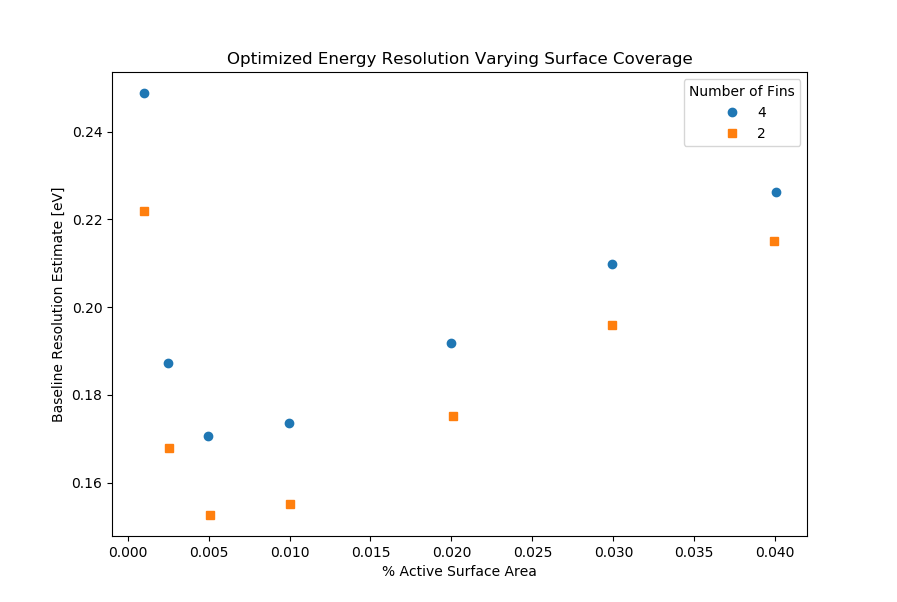

In [12]:
f, ax = plt.subplots(1)
ax.set_title("Optimized Energy Resolution Varying Surface Coverage")
ax.plot(coverages_4fin, res_4fin, "o", label = "4")
ax.plot(coverages_2fin, res_2fin, 's', label = "2")
plt.legend(title = "Number of Fins")
ax.set_xlabel("% Active Surface Area")
ax.set_ylabel("Baseline Resolution Estimate [eV]")
plt.show()

<IPython.core.display.Javascript object>


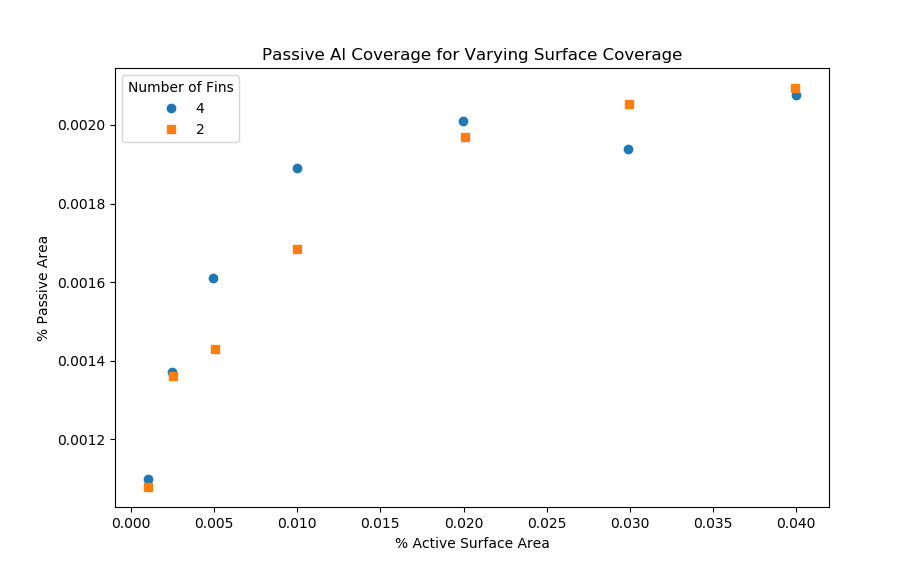

In [13]:
f, ax = plt.subplots(1)
ax.set_title("Passive Al Coverage for Varying Surface Coverage")
ax.plot(coverages_4fin, pass_area_4fin, "o", label = "4")
ax.plot(coverages_2fin, pass_area_2fin, 's', label = "2")
plt.legend(title = "Number of Fins")
ax.set_xlabel("% Active Surface Area")
ax.set_ylabel("% Passive Area")
plt.show()

<IPython.core.display.Javascript object>


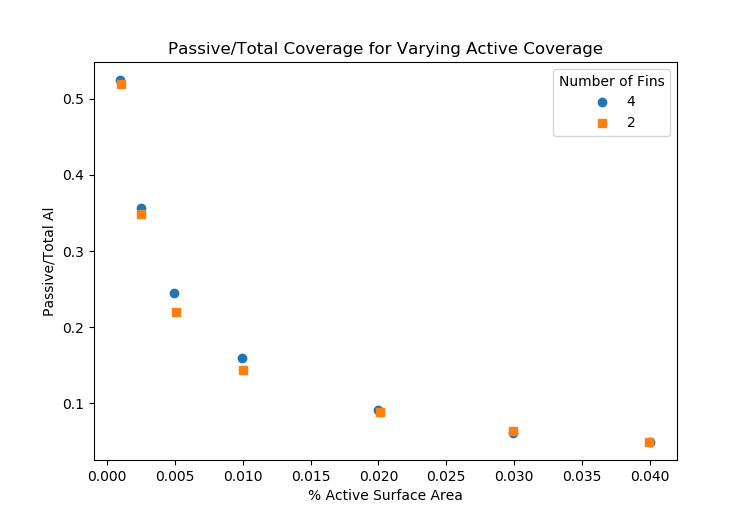

In [19]:
pass_tot_4fin = []
pass_tot_2fin = []

for i,j in zip(pass_area_4fin, tot_cov_4fin):
    pass_tot_4fin.append(i/j)
for k,l in zip(pass_area_2fin, tot_cov_2fin):
    pass_tot_2fin.append(k/l)
    
f, ax = plt.subplots(1)
ax.set_title("Passive/Total Coverage for Varying Active Coverage")
ax.plot(coverages_4fin, pass_tot_4fin, "o", label = "4")
ax.plot(coverages_2fin, pass_tot_2fin, 's', label = "2")
plt.legend(title = "Number of Fins")
ax.set_xlabel("% Active Surface Area")
ax.set_ylabel("Passive/Total Al")
plt.show()

<IPython.core.display.Javascript object>


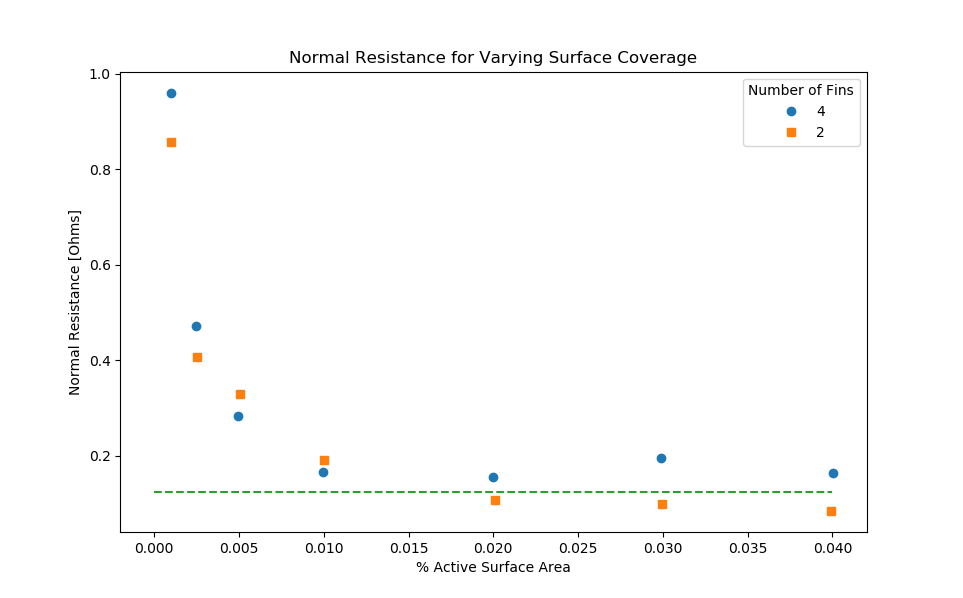

In [23]:
x = [0., 0.04]
y = [0.125, 0.125]

f, ax = plt.subplots(1)
ax.set_title("Normal Resistance for Varying Surface Coverage")
ax.plot(coverages_4fin, rn_4fin, "o", label = "4")
ax.plot(coverages_2fin, rn_2fin, 's', label = "2")
ax.plot(x, y, '--')
plt.legend(title = "Number of Fins")
ax.set_xlabel("% Active Surface Area")
ax.set_ylabel("Normal Resistance [Ohms]")
plt.show()

<IPython.core.display.Javascript object>


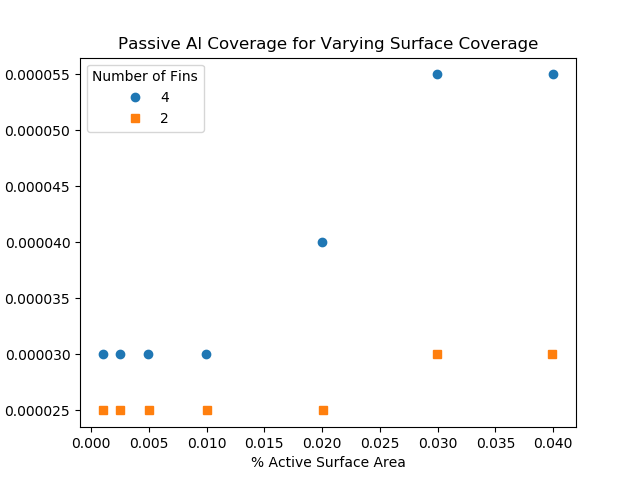

In [16]:
f, ax = plt.subplots(1)
ax.set_title("Passive Al Coverage for Varying Surface Coverage")
ax.plot(coverages_4fin, tes_l_4fin, "o", label = "4")
ax.plot(coverages_2fin, tes_l_2fin, 's', label = "2")
plt.legend(title = "Number of Fins")
ax.set_xlabel("% Active Surface Area")
ax.set_ylabel("TES Length [m]")
plt.show()

<IPython.core.display.Javascript object>


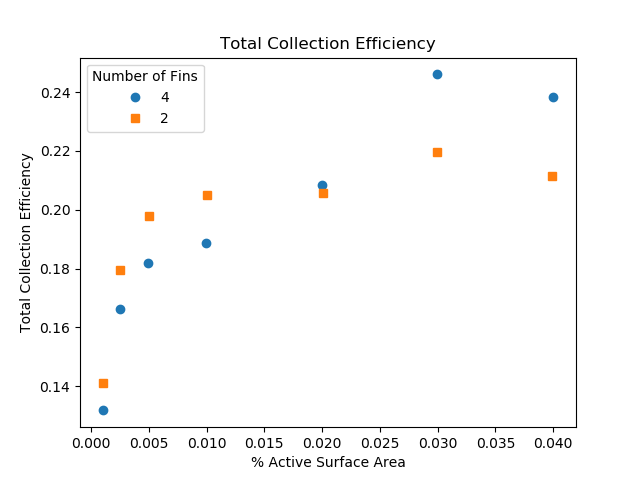

In [17]:
f, ax = plt.subplots(1)
ax.set_title("Total Collection Efficiency")
ax.plot(coverages_4fin, tot_eff_4fin, "o", label = "4")
ax.plot(coverages_2fin, tot_eff_2fin, 's', label = "2")
plt.legend(title = "Number of Fins")
ax.set_xlabel("% Active Surface Area")
ax.set_ylabel("Total Collection Efficiency")
plt.show()

<IPython.core.display.Javascript object>


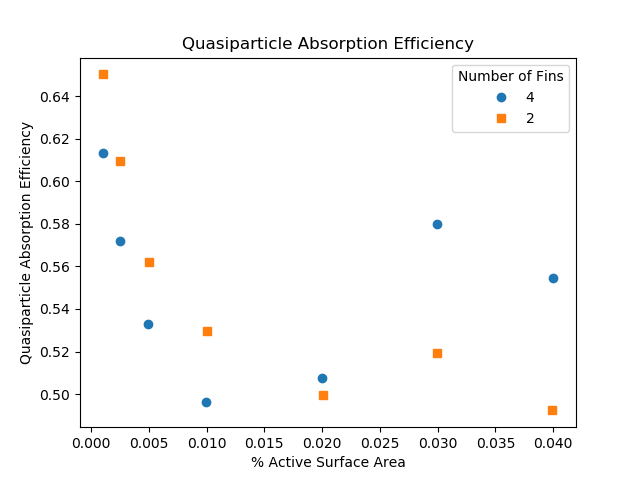

In [18]:
f, ax = plt.subplots(1)
ax.set_title("Quasiparticle Absorption Efficiency")
ax.plot(coverages_4fin, qp_eff_4fin, "o", label = "4")
ax.plot(coverages_2fin, qp_eff_2fin, 's', label = "2")
plt.legend(title = "Number of Fins")
ax.set_xlabel("% Active Surface Area")
ax.set_ylabel("Quasiparticle Absorption Efficiency")
plt.show()